In [2]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy import ma
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from cellpose import utils
import cv2
from scipy import ndimage
from pathlib import Path
import pandas as pd
from skimage import io, exposure


# show the used python env
print("Using:", sys.executable)

Using: /home/chrism/miniconda3/envs/cellpose3/bin/python


In [8]:
from skimage.filters import threshold_otsu
import shutil

# nuclei extration
debug = False
border = 0

data_path = Path('/home/chrism/datasets/dapidl/tumorcell/train')

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

for otsu_correction in np.arange(0.7, 1.3, 0.02):
    print(f"Otsu correction: {otsu_correction}")
    area_pixel = 0.512 * 0.512
    nuclei_path = data_path / "nuclei"
    cells_path = data_path / "cells"
    czi_path = data_path / "czi"
    exclude_path = data_path / "exclude"
    debug_path = data_path / "debug_otsu"
    classification_path = data_path / f"classification_otsu_{otsu_correction:.2f}"
    nuclei_tumorcells_path = data_path / f"nuclei_tumorcells_otsu_{otsu_correction:.2f}"
    results = []
    
    for nuclei_masks_file in nuclei_path.glob("**/*.npy"):
        print(nuclei_masks_file)
        slide = nuclei_masks_file.parent.parts[-1]
        group = nuclei_masks_file.parent.parts[-2]
        
        exclude_masks = exclude_path / nuclei_masks_file.name
        if not exclude_masks.exists():
            print(f"{exclude_masks} does not exist. Skipping ...")
            continue
            
        czi_file_name = nuclei_masks_file.name[0:-8] + '.czi'
        czi_file = czi_path / czi_file_name
        if not czi_file.exists():
            print(f"{czi_file} does not exist. Skipping ...")
            continue
            
        # cells_masks = cells_path / nuclei_masks_file.name
        # if not cells_masks.exists():
        #     print(f"{cells_masks} does not exist. Skipping ...")
        #     continue
        
    
        nuclei_seg = np.load(nuclei_masks_file, allow_pickle=True).item()
        nuclei_masks = nuclei_seg["masks"]
        num_nuclei = nuclei_masks.max()
        
        exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
        exclude_masks = exclude_seg["masks"] > 0
    
        # cells_seg = np.load(cells_masks, allow_pickle=True).item()
        # cells_masks = cells_seg["masks"]
        # num_cells = cells_masks.max()
        
        num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
        area = num_pixels * area_pixel
        # print(area)
        nuclei_per_um2 = num_nuclei / area
        # print(cells_per_um2)
    
        with pyczi.open_czi(str(czi_file)) as czidoc:
            ch0 = czidoc.read(plane={'C': 0})
            dapi = ch0[..., 0]
            ch1 = czidoc.read(plane={'C': 1})
            mrc1 = ch1[..., 0]
            # ch2 = czidoc.read(plane={'C': 2})
            # vwf = ch2[..., 0]
            # ch3 = czidoc.read(plane={'C': 3})
            # f480 = ch3[..., 0]
    
        if debug:
            # d_slices = utils.find_objects(masks)
            # d_mrc1 = mrc1.copy()
            # for i,si in enumerate(slices):
            #     if si is not None:
            #         sr,sc = si
            #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
            #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            #         ax.contours(
            #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                    
            plt.ioff()
            fig, ax = plt.subplots(figsize=(13, 10))
            ax.imshow(mrc1, cmap=cm_red)
    
        # cells_slices = utils.find_objects(cells_masks)
        # cells_centers = ndimage.center_of_mass(mrc1, cells_masks, index=np.arange(1, num_cells + 1))
    
        # for i, (si, (row, col)) in enumerate(zip(cells_slices, cells_centers)): 
        #     if np.any((cells_masks == i+1) & exclude_masks):
        #         print(f"Cell {i+1} intersecting exclude region. Skipping ...")
        #         continue
        #     if si is not None:
        #         sr, sc = si
        #         cell_mask = cells_masks[sr, sc] != (i+1)
        #         dapi_ma = ma.masked_array(dapi[sr, sc], mask)
    
        
        slices = utils.find_objects(nuclei_masks)
        nuclei_centers = ndimage.center_of_mass(dapi, nuclei_masks, index=np.arange(1, num_nuclei + 1))
        
        # pass 1 otsu
        nucleus_means = []
        for i, (si, (row, col)) in enumerate(zip(slices, nuclei_centers)):
            sr, sc = si
            if sr.start - border >= 0:
                sr_start = sr.start - border
            else:
                sr_start = sr.start
            if sr.stop + border < 1040:
                sr_stop = sr.stop + border
            else:
                sr_stop = sr.stop
            if sc.start - border >= 0:
                sc_start = sc.start - border
            else:
                sc_start = sc.start
            if sc.stop + border < 1388:
                sc_stop = sc.stop + border
            else:
                sc_stop = sc.stop
            mask = nuclei_masks[sr_start:sr_stop, sc_start:sc_stop] != (i+1)
            dapi_ma = ma.masked_array(dapi[sr_start:sr_stop, sc_start:sc_stop], mask)
            mrc1_ma = ma.masked_array(mrc1[sr_start:sr_stop, sc_start:sc_stop], mask)
            nucleus_mask = np.ones(nuclei_masks.shape, dtype=bool)
            nucleus_mask[sr_start:sr_stop, sc_start:sc_stop] = mask
            if np.any((nuclei_masks == i+1) & exclude_masks):
                # print(f"Nucleus {i+1} intersecting exclude region. Skipping ...")
                continue
            if si is None:
                print(f"Nucleus {i+1} no si. Skipping ...")
                continue
            
            # mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
            # vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            # f480_ma = ma.masked_array(f480[sr, sc], mask)
            # mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
            # f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
            # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
            mrc1mean = mrc1_ma.mean()
            nucleus_means.append(mrc1mean)
        deepred_threshold = threshold_otsu(np.array(nucleus_means)) * otsu_correction
        print("Otsu's threshold:", deepred_threshold)
    
        
        # pass 2
        for i, (si, (row, col)) in enumerate(zip(slices, nuclei_centers)): 
            sr, sc = si
            if sr.start - border >= 0:
                sr_start = sr.start - border
            else:
                sr_start = sr.start
            if sr.stop + border < 1040:
                sr_stop = sr.stop + border
            else:
                sr_stop = sr.stop
            if sc.start - border >= 0:
                sc_start = sc.start - border
            else:
                sc_start = sc.start
            if sc.stop + border < 1388:
                sc_stop = sc.stop + border
            else:
                sc_stop = sc.stop
            mask = nuclei_masks[sr_start:sr_stop, sc_start:sc_stop] != (i+1)
            dapi_ma = ma.masked_array(dapi[sr_start:sr_stop, sc_start:sc_stop], mask)
            mrc1_ma = ma.masked_array(mrc1[sr_start:sr_stop, sc_start:sc_stop], mask)
            nucleus_mask = np.ones(nuclei_masks.shape, dtype=bool)
            nucleus_mask[sr_start:sr_stop, sc_start:sc_stop] = mask
            if np.any((nuclei_masks == i+1) & exclude_masks):
                # print(f"Nucleus {i+1} intersecting exclude region. Skipping ...")
                nuclei_masks[np.invert(nucleus_mask)] = 0
                continue
            if si is None:
                print(f"Nucleus {i+1} no si. Skipping ...")
                nuclei_masks[np.invert(nucleus_mask)] = 0
                continue
            
            # mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
            # vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            # f480_ma = ma.masked_array(f480[sr, sc], mask)
            # mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
            # f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
            # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
            mrc1mean = mrc1_ma.mean()
            
            if mrc1mean > deepred_threshold:
                nucleus_class = "tumorcell"
                nuclei_masks[np.invert(nucleus_mask)] = 1
            else:
                nucleus_class = "othercell"
                nuclei_masks[np.invert(nucleus_mask)] = 2
            
            # print(row, col)
            row = round(row)
            col = round(col)
            
            # save image
    
            im12 = dapi_ma.filled(0)
            # im8 = exposure.rescale_intensity(im12, in_range=(0, 2**12), out_range=np.uint8)
            im8 = exposure.rescale_intensity(dapi[sr, sc], in_range=(0, 2**12), out_range=np.uint8)
            png_file_name = f"{czi_file_name}_{i:0>6}.png"
            png_file_path = classification_path / nucleus_class / png_file_name
            if not png_file_path.parent.exists():
                png_file_path.parent.mkdir(parents=True, exist_ok=True)
            io.imsave(png_file_path, im8)
            results_row = {'czi': czi_file_name, 'nucleus_no': i, 'class': nucleus_class, 'filename': png_file_name, 'mean(dapi)': dapi_ma.mean(), 'mean(deepred)': mrc1mean, 'area nucleus': mask.sum(), 'pos nucleus': f'{row},{col}', 'deepred threshold': deepred_threshold}
            results.append(results_row)
    
            if debug:
                ax.text(col, row, str(i), color="white")
                ax.scatter(col, row, c="yellow", marker=".")
                # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                # d_contour = d_contours[0]
                
                # M = cv2.moments(d_contour)
                # x = int(M["m10"] / M["m00"])
                # y = int(M["m01"] / M["m00"])
                
                # xs = [v[0][0] - x for v in d_contour]
                # ys = [-(v[0][1] - y) for v in d_contour]
                
                # ax.plot(xs, ys, color="green")
        
        nuclei_seg["masks"] = nuclei_masks
        if not nuclei_tumorcells_path.exists():
            nuclei_tumorcells_path.mkdir(parents=True, exist_ok=True)
        np.save(nuclei_tumorcells_path / nuclei_masks_file.name, nuclei_seg)
        nuclei_tif_file_name = nuclei_masks_file.name[:-8] + ".tif"
        
        shutil.copy(nuclei_path / nuclei_tif_file_name, nuclei_tumorcells_path / nuclei_tif_file_name)
        
    
        if debug:
            debug_file_name = nuclei_masks_file.name + ".png"
            debug_file = debug_path / debug_file_name
            debug_file.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(str(debug_file))
            plt.close(fig)
            plt.ion()
            
        
    df = pd.DataFrame(results)
    out_fn = f"results_nuclei_otsu_{otsu_correction:.2f}.xlsx"
    df.to_excel(data_path / out_fn)

Otsu correction: 0.7
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1007.1013937684911


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 962.8920875323595


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1197.4512413506036
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 932.6888477138369
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 967.3987748579543
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1058.9626511922534


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 814.8395805104133


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1148.5178648358344


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 927.4115742017964


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1221.9599176742531
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1057.4412386363638
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 941.071631184608


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.70/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 967.5451918857578
Otsu correction: 0.72
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1035.8757193047338


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 990.4032900332841


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1231.6641339606208
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 959.3371005056609
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 995.0387398538959
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1089.2187269406033


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 838.1207113821393


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1181.3326609740013


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 953.9090477504192


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1256.873058179232
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1087.6538454545455
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 967.9593920755968


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.72/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 995.189340225351
Otsu correction: 0.74
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1064.6500448409763


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1017.9144925342086


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1265.8770265706382
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 985.9853532974848
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1022.6787048498375
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1119.4748026889536


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 861.4018422538655


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1214.147457112168


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 980.406521299042


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1291.7861986842106
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1117.8664522727274
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 994.8471529665857


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.74/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1022.8334885649441
Otsu correction: 0.76
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1093.424370377219


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1045.4256950351332


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1300.0899191806554
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1012.6336060893088
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1050.3186698457791
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1149.7308784373035


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 884.6829731255916


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1246.9622532503347


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1006.9039948476648


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1326.6993391891892
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1148.0790590909091
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1021.7349138575745


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.76/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1050.4776369045371
Otsu correction: 0.78
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1122.1986959134615


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1072.9368975360578


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1334.3028117906726
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1039.2818588811328
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1077.9586348417206
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1179.9869541856538


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 907.9641039973178


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1279.7770493885014


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1033.4014683962876


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1361.6124796941679
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1178.291665909091
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1048.6226747485632


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.78/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1078.1217852441303
Otsu correction: 0.8
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1150.9730214497042


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1100.4481000369824


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1368.51570440069
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1065.9301116729566
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1105.5985998376623
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1210.2430299340037


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 931.2452348690439


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1312.5918455266683


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1059.8989419449103


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1396.5256201991467
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1208.5042727272728
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1075.510435639552


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.80/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1105.7659335837234
Otsu correction: 0.8200000000000001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1179.747346985947


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1127.959302537907


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1402.7285970107073
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1092.5783644647806
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1133.2385648336037
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1240.499105682354


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 954.52636574077


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1345.406641664835


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1086.3964154935331


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1431.4387607041253
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1238.7168795454547
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1102.3981965305409


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.82/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1133.4100819233165
Otsu correction: 0.8400000000000001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1208.5216725221894


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1155.4705050388316


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1436.9414896207245
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1119.2266172566046
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1160.8785298295454
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1270.7551814307042


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 977.8074966124962


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1378.2214378030017


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1112.893889042156


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1466.351901209104
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1268.9294863636367
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1129.2859574215297


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.84/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1161.0542302629096
Otsu correction: 0.8600000000000001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1237.2959980584321


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1182.9817075397561


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1471.1543822307417
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1145.8748700484284
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1188.518494825487
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1301.0112571790542


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1001.0886274842222


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1411.0362339411683


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1139.3913625907787


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1501.2650417140828
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1299.1420931818184
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1156.1737183125185


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.86/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1188.6983786025028
Otsu correction: 0.8800000000000001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1266.0703235946748


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1210.4929100406807


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1505.3672748407591
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1172.5231228402524
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1216.1584598214286
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1331.2673329274044


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1024.3697583559483


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1443.851030079335


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1165.8888361394015


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1536.1781822190615
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1329.3547000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1183.0614792035074


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.88/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1216.342526942096
Otsu correction: 0.9000000000000001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1294.8446491309173


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1238.0041125416053


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1539.5801674507763
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1199.1713756320764
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1243.7984248173702
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1361.5234086757544


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1047.6508892276745


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1476.665826217502


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1192.3863096880243


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1571.09132272404
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1359.567306818182
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1209.9492400944962


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.90/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1243.986675281689
Otsu correction: 0.9200000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1323.61897466716


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1265.51531504253


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1573.7930600607936
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1225.8196284239002
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1271.4383898133117
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1391.7794844241046


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1070.9320200994005


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1509.4806223556686


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1218.883783236647


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1606.004463229019
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1389.779913636364
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1236.837000985485


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.92/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1271.6308236212822
Otsu correction: 0.9400000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1352.3933002034028


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1293.0265175434545


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1608.005952670811
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1252.4678812157242
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1299.0783548092534
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1422.0355601724548


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1094.2131509711267


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1542.2954184938353


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1245.3812567852697


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1640.9176037339976
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1419.992520454546
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1263.7247618764738


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.94/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1299.2749719608753
Otsu correction: 0.9600000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1381.1676257396452


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1320.537720044379


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1642.2188452808282
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1279.1161340075482
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1326.7183198051948
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1452.2916359208048


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1117.4942818428528


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1575.110214632002


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1271.8787303338925


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1675.8307442389762
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1450.2051272727276
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1290.6125227674627


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.96/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1326.9191203004684
Otsu correction: 0.9800000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1409.941951275888


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1348.0489225453036


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1676.4317378908454
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1305.7643867993722
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1354.3582848011365
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1482.547711669155


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1140.7754127145788


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1607.9250107701687


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1298.3762038825153


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1710.7438847439548
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1480.4177340909096
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1317.5002836584515


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_0.98/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1354.5632686400613
Otsu correction: 1.0000000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1438.7162768121304


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1375.5601250462282


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1710.6446305008628
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1332.412639591196
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1381.998249797078
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1512.803787417505


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1164.056543586305


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1640.7398069083356


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1324.873677431138


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1745.6570252489337
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1510.6303409090913
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1344.3880445494403


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.00/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1382.2074169796545
Otsu correction: 1.0200000000000002
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1467.4906023483732


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1403.0713275471528


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1744.85752311088
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1359.06089238302
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1409.6382147930196
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1543.0598631658552


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1187.3376744580312


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1673.5546030465023


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1351.3711509797608


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1780.5701657539123
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1540.8429477272732
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1371.2758054404292


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.02/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1409.8515653192476
Otsu correction: 1.0400000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1496.2649278846159


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1430.5825300480774


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1779.0704157208972
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1385.709145174844
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1437.278179788961
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1573.3159389142054


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1210.6188053297572


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1706.369399184669


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1377.8686245283836


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1815.483306258891
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1571.0555545454552
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1398.163566331418


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.04/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1437.4957136588407
Otsu correction: 1.0600000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1525.0392534208584


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1458.093732549002


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1813.2833083309147
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1412.3573979666678
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1464.9181447849028
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1603.5720146625554


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1233.8999362014833


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1739.1841953228356


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1404.3660980770064


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1850.3964467638698
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1601.2681613636369
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1425.0513272224068


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.06/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1465.1398619984338
Otsu correction: 1.0800000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1553.813578957101


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1485.6049350499266


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1847.4962009409319
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1439.0056507584918
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1492.5581097808445
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1633.8280904109056


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1257.1810670732095


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1771.9989914610023


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1430.8635716256292


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1885.3095872688484
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1631.4807681818188
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1451.9390881133957


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.08/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1492.784010338027
Otsu correction: 1.1000000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1582.5879044933438


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1513.1161375508511


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1881.709093550949
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1465.6539035503158
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1520.198074776786
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1664.0841661592556


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1280.4621979449355


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1804.8137875991692


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1457.361045174252


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1920.222727773827
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1661.6933750000005
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1478.8268490043845


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.10/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1520.42815867762
Otsu correction: 1.1200000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1611.3622300295863


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1540.6273400517757


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1915.9219861609665
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1492.3021563421398
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1547.8380397727276
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1694.3402419076058


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1303.7433288166617


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1837.628583737336


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1483.8585187228748


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1955.1358682788057
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1691.9059818181825
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1505.7146098953733


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.12/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1548.0723070172132
Otsu correction: 1.1400000000000003
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1640.136555565829


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1568.1385425527003


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1950.1348787709837
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1518.9504091339636
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1575.478004768669
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1724.596317655956


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1327.0244596883879


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1870.4433798755026


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1510.3559922714976


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 1990.0490087837845
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1722.1185886363644
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1532.6023707863621


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.14/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1575.7164553568064
Otsu correction: 1.1600000000000004
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1668.9108811020715


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1595.6497450536249


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 1984.347771381001
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1545.5986619257876
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1603.1179697646107
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1754.852393404306


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1350.305590560114


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1903.2581760136693


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1536.8534658201204


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2024.9621492887632
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1752.331195454546
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1559.490131677351


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.16/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1603.3606036963995
Otsu correction: 1.1800000000000004
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1697.6852066383142


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1623.1609475545495


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2018.5606639910181
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1572.2469147176116
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1630.7579347605522
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1785.1084691526562


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1373.58672143184


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1936.072972151836


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1563.3509393687432


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2059.875289793742
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1782.543802272728
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1586.3778925683398


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.18/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1631.0047520359926
Otsu correction: 1.2000000000000004
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1726.459532174557


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1650.672150055474


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2052.7735566010356
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1598.8951675094354
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1658.3978997564939
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1815.3645449010062


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1396.8678523035662


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 1968.887768290003


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1589.848412917366


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2094.7884302987204
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1812.7564090909098
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1613.2656534593286


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.20/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1658.6489003755855
Otsu correction: 1.2200000000000004
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1755.2338577107994


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1678.1833525563986


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2086.986449211053
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1625.5434203012594
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1686.0378647524353
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1845.6206206493564


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1420.1489831752924


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 2001.7025644281696


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1616.3458864659888


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2129.7015708036993
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1842.9690159090917
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1640.1534143503175


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.22/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1686.2930487151787
Otsu correction: 1.2400000000000004
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1784.008183247042


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1705.6945550573232


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2121.19934182107
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1652.1916730930834
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1713.677829748377
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1875.8766963977066


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1443.4301140470184


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 2034.5173605663363


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1642.8433600146116


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2164.614711308678
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1873.1816227272736
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1667.0411752413063


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.24/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1713.9371970547718
Otsu correction: 1.2600000000000005
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1812.7825087832848


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1733.2057575582478


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2155.412234431087
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1678.8399258849072
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1741.3177947443185
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1906.1327721460566


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1466.7112449187446


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 2067.332156704503


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1669.3408335632344


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2199.5278518136565
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1903.3942295454553
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1693.9289361322951


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.26/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1741.581345394365
Otsu correction: 1.2800000000000005
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1841.5568343195273


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1760.7169600591724


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2189.625127041105
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1705.4881786767312
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1768.9577597402601
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1936.3888478944068


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1489.9923757904708


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 2100.1469528426696


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1695.8383071118571


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2234.4409923186354
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1933.6068363636373
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1720.816697023284


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.28/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1769.225493733958
Otsu correction: 1.3000000000000005
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy
Otsu's threshold: 1870.33115985577


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy
Otsu's threshold: 1788.228162560097


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
Otsu's threshold: 2223.838019651122
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
Otsu's threshold: 1732.1364314685552
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
Otsu's threshold: 1796.5977247362018
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy
Otsu's threshold: 1966.6449236427568


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy
Otsu's threshold: 1513.2735066621967


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy
Otsu's threshold: 2132.9617489808365


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy
Otsu's threshold: 1722.3357806604797


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
Otsu's threshold: 2269.3541328236142
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
Otsu's threshold: 1963.819443181819
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy
Otsu's threshold: 1747.7044579142728


/tmp/ipykernel_232059/1831746247.py:219: UserWarning: /home/chrism/datasets/tumorcells/classification_otsu_1.30/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
Otsu's threshold: 1796.8696420735512


<Axes: >

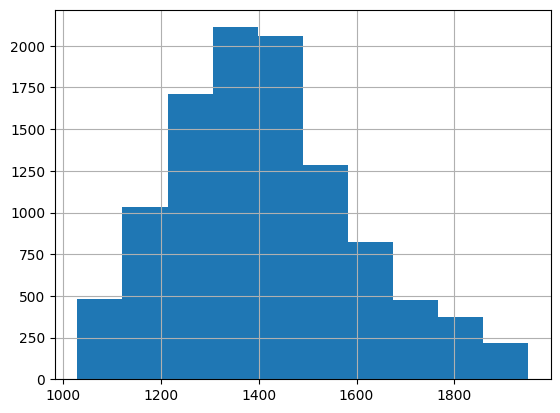

In [4]:
df['mean(deepred)'].hist()

In [8]:
si & mask

ValueError: operands could not be broadcast together with shapes (2,) (7,18) 

In [16]:
np.save("test.npy", nuclei_seg, allow_pickle=True)

In [12]:
nuclei_masks[si]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=uint16)

In [34]:
import matplotlib.pyplot as plt
plt.show()